# Uber Data Anlytics

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('ncr_ride_bookings.csv')

In [3]:
df.shape

(150000, 21)

In [4]:
df.head()

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,...,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,...,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card
3,2024-10-21,17:17:25,"""CNR8906825""",Completed,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,...,NaN,NaN,NaN,NaN,NaN,416.0,34.02,4.6,5.0,UPI
4,2024-09-16,22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,...,NaN,NaN,NaN,NaN,NaN,737.0,48.21,4.1,4.3,UPI


In [5]:
df.columns

Index(['Date', 'Time', 'Booking ID', 'Booking Status', 'Customer ID',
       'Vehicle Type', 'Pickup Location', 'Drop Location', 'Avg VTAT',
       'Avg CTAT', 'Cancelled Rides by Customer',
       'Reason for cancelling by Customer', 'Cancelled Rides by Driver',
       'Driver Cancellation Reason', 'Incomplete Rides',
       'Incomplete Rides Reason', 'Booking Value', 'Ride Distance',
       'Driver Ratings', 'Customer Rating', 'Payment Method'],
      dtype='object')

# Part 1. Booking cancellation estimator

This model will predict whether booking will be cancelled or completed

First, we will cluster each columns into categories to determine how each categories affect cancellation rate.

## Exploratory Data Analysis 

In [6]:
df.describe()

,Avg VTAT,Avg CTAT,Cancelled Rides by Customer,Cancelled Rides by Driver,Incomplete Rides,Booking Value,Ride Distance,Driver Ratings,Customer Rating
count,139500.000000,102000.000000,10500.0,27000.0,9000.0,102000.000000,102000.000000,93000.000000,93000.000000
mean,8.456352,29.149636,1.0,1.0,1.0,508.295912,24.637012,4.230992,4.404584
std,3.773564,8.902577,0.0,0.0,0.0,395.805774,14.002138,0.436871,0.437819
min,2.000000,10.000000,1.0,1.0,1.0,50.000000,1.000000,3.000000,3.000000
25%,5.300000,21.600000,1.0,1.0,1.0,234.000000,12.460000,4.100000,4.200000
50%,8.300000,28.800000,1.0,1.0,1.0,414.000000,23.720000,4.300000,4.500000
75%,11.300000,36.800000,1.0,1.0,1.0,689.000000,36.820000,4.600000,4.800000
max,20.000000,45.000000,1.0,1.0,1.0,4277.000000,50.000000,5.000000,5.000000


We will first see the distribution of each columns visually.

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

We want to see distribution by numerical category.

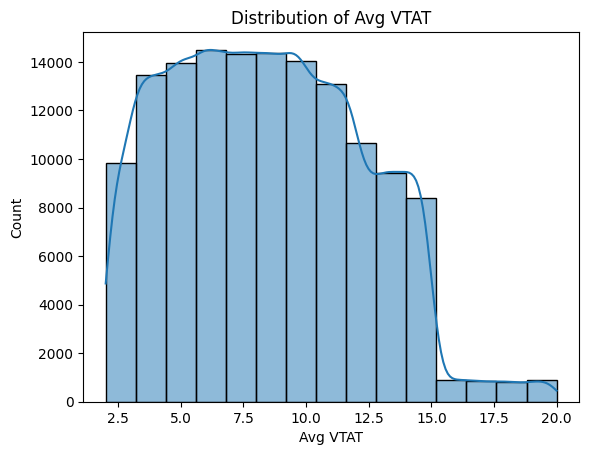

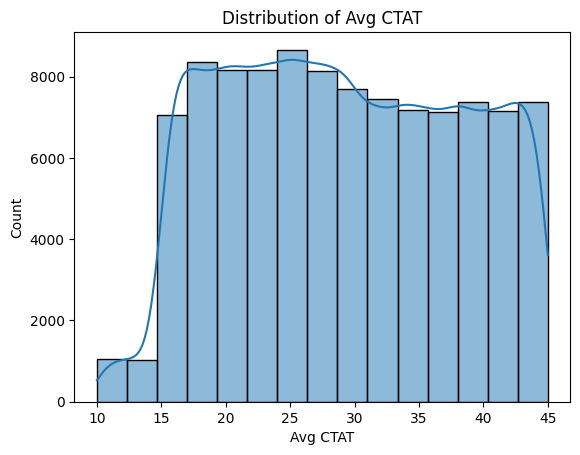

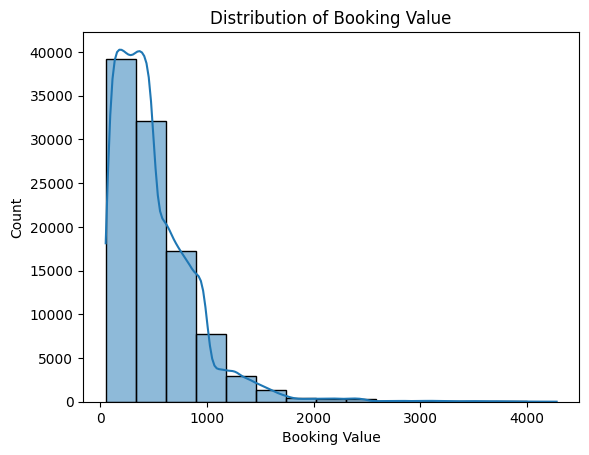

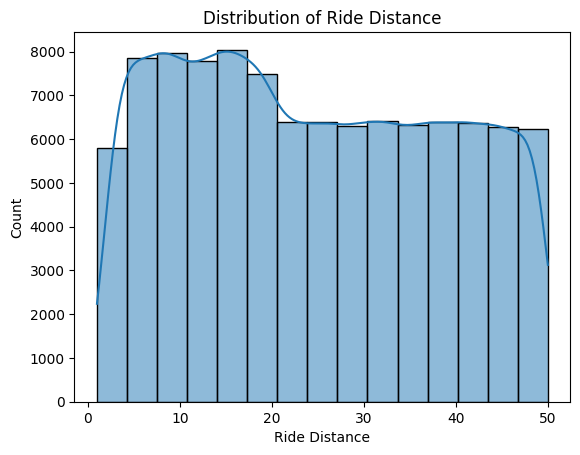

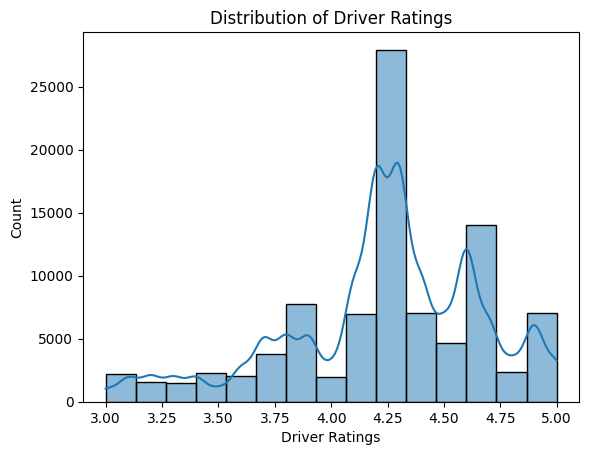

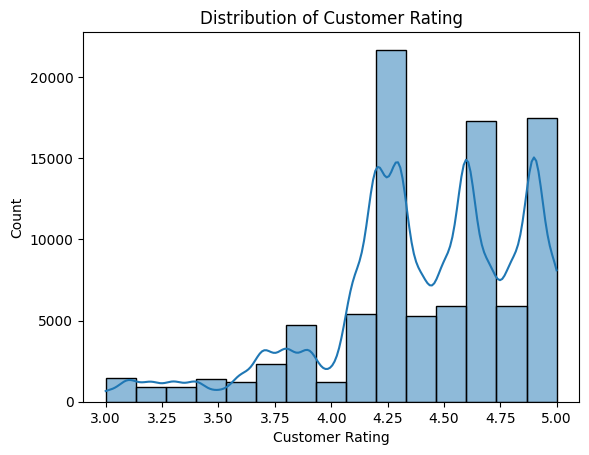

In [8]:
num_cols = ['Avg VTAT', 'Avg CTAT', 'Booking Value', 'Ride Distance', 'Driver Ratings', 'Customer Rating']
for col in num_cols:
    sns.histplot(df[col], kde = True, bins = 15)
    plt.title(f'Distribution of {col}')
    plt.show()


Now we will seperate target, which is cancellation by customer and see how distribution changes.

In [9]:
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Hour'] = pd.to_datetime(df['Time'], format = '%H:%M:%S').dt.hour

In [10]:
df['Cancelled Rides by Customer'] = df['Cancelled Rides by Customer'].fillna(0)
df['Cancelled Rides by Driver'] = df['Cancelled Rides by Driver'].fillna(0)

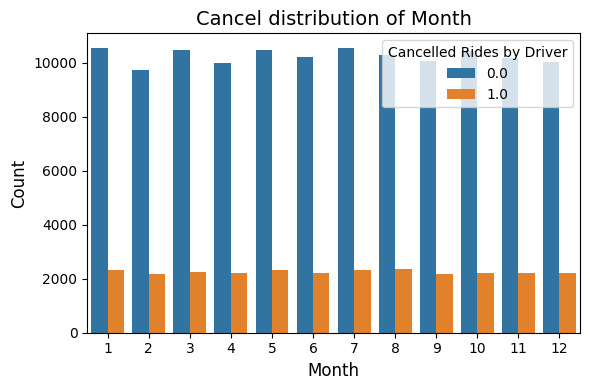

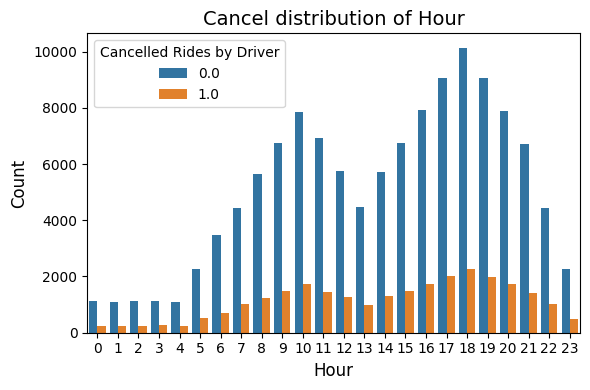

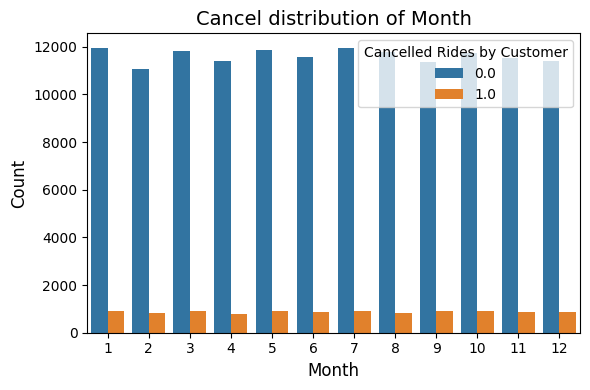

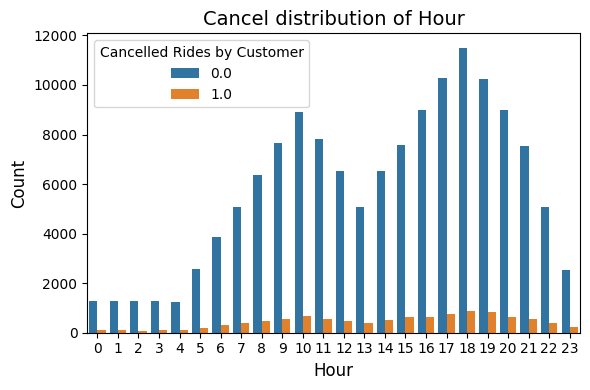

In [11]:
cancelled = ['Cancelled Rides by Driver', 'Cancelled Rides by Customer']
Time = ['Month', 'Hour']
for h in cancelled:
    for time in Time:
        plt.figure(figsize = (6,4))
        sns.countplot(data = df, x = time, hue = h)
        plt.title(f'Cancel distribution of {time}', fontsize = 14)
        plt.xlabel(f'{time}', fontsize = 12)
        plt.ylabel(f'Count', fontsize = 12)
        plt.tight_layout()
        plt.show()

From here we can investigate that driver's cancel more than customers. Regarding months, we can see that cancellation and bookings are relatively similar. However, people book most on 6:00 PM and 10:00 AM and people cancel the most at those two periods.

Now, we will see what vehicles drivers use the most.

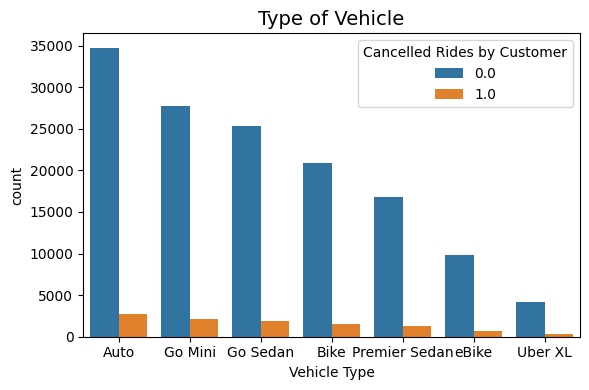

In [12]:
plt.figure(figsize = (6,4))
sns.countplot(data = df, x = 'Vehicle Type', hue = h, order = df['Vehicle Type'].value_counts().index)
plt.title(f'Type of Vehicle', fontsize = 14)
plt.tight_layout()
plt.show()

Now we can examine why customers or drivers cancelled their bookings.

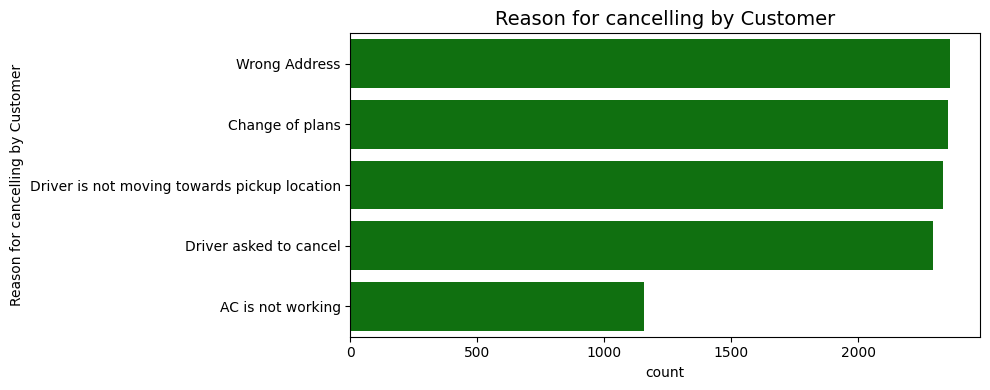

In [13]:
plt.figure(figsize = (10,4))
sns.countplot(y = 'Reason for cancelling by Customer', data = df, order= df['Reason for cancelling by Customer'].value_counts().index, color = 'green')
plt.title('Reason for cancelling by Customer', fontsize = 14)
plt.tight_layout()
plt.show()

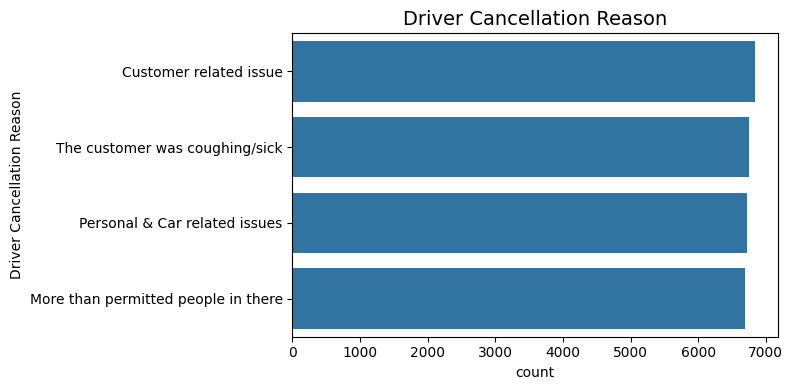

In [14]:
plt.figure(figsize = (8,4))
sns.countplot(y = 'Driver Cancellation Reason', data = df, order= df['Driver Cancellation Reason'].value_counts().index, )
plt.title('Driver Cancellation Reason', fontsize = 14)
plt.tight_layout()
plt.show()

In [15]:
df.head()

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method,Month,Hour
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,12
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,...,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI,11,18
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,...,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card,8,8
3,2024-10-21,17:17:25,"""CNR8906825""",Completed,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,...,NaN,NaN,NaN,416.0,34.02,4.6,5.0,UPI,10,17
4,2024-09-16,22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,...,NaN,NaN,NaN,737.0,48.21,4.1,4.3,UPI,9,22


# Data Preprocessing

Our goal is to predict whether custor will cancel the ride or not. There for target y will the 'Cancelled Rides by Customer'.

In [16]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import warnings
warnings.filterwarnings('ignore')

cat_cols = ['Vehicle Type', 'Pickup Location', 'Drop Location', 'Payment Method']
num_cols = ['Avg VTAT', 'Avg CTAT', 'Booking Value', 'Ride Distance', 'Driver Ratings', 'Customer Rating', 'Month', 'Hour']
X = df[['Vehicle Type', 'Pickup Location', 'Drop Location', 'Avg VTAT',
       'Avg CTAT', 'Booking Value', 'Ride Distance',
       'Driver Ratings', 'Customer Rating', 'Payment Method', 'Month', 'Hour']]
y = df['Cancelled Rides by Customer']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 26, stratify = y)

We will split data into train set and test set and validation set by 70/15/15. Then we will compare Logistic regression classifier and LGBMClassifier.

## Create Pipeline

In [17]:
num_pipeline = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown = 'ignore'))
])

preprocessor = ColumnTransformer(transformers = [
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

In [18]:
pipeline1 = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter = 1000, random_state = 26, class_weight = 'balanced'))
])

## Evaluate Logistic regression

In [19]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
kf1 = StratifiedKFold(n_splits = 7, shuffle = True, random_state = 26)
cv_scores = cross_val_score(pipeline1, X_train, y_train, cv = kf1, scoring = 'roc_auc')
print(f'ROC-AUC scores are: ', cv_scores)
print(f'Mean ROC-AUC score: ', np.mean(cv_scores))

ROC-AUC scores are:  [0.86947192 0.8699195  0.8746579  0.88042709 0.88240989 0.87145874
 0.87478417]
Mean ROC-AUC score:  0.87473274388968


In [20]:
pipeline1.fit(X_train, y_train)

y_test_pred = pipeline1.predict(X_test)

print("Accuracy for logistic regression is ", accuracy_score(y_test, y_test_pred))
print("F1-score for logistic regression is ", f1_score(y_test, y_test_pred))
print("Classification result:\n", classification_report(y_test, y_test_pred))

Accuracy for logistic regression is  0.7420666666666667
F1-score for logistic regression is  0.2979495554345854
Classification result:
               precision    recall  f1-score   support

         0.0       0.98      0.74      0.84     27900
         1.0       0.18      0.78      0.30      2100

    accuracy                           0.74     30000
   macro avg       0.58      0.76      0.57     30000
weighted avg       0.92      0.74      0.80     30000



We started logistic classifier with stratifying target, but we have bad f1 score. Therefore we should consider tree based model (LGBM classifier).

## LGBM classifier model

In [21]:
lgbm_classifier = lgb.LGBMClassifier(
    objective = 'binary',
    n_estimators = 1000,
    learning_rate = 0.05,
    random_state = 26,
    class_weight = 'balanced',
    verbose =-1
)

pipeline2 = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', lgbm_classifier)
])

## Evaluate LGBM classifier

In [22]:
kf2 = StratifiedKFold(n_splits = 7, shuffle = True, random_state = 26)
cv_scores = cross_val_score(pipeline2, X_train, y_train, cv = kf2, scoring = 'roc_auc')
print(f'ROC-AUC scores are: ', cv_scores)
print(f'Mean ROC-AUC score: ', np.mean(cv_scores))

ROC-AUC scores are:  [0.96222919 0.96172725 0.96135038 0.96260193 0.96497123 0.96470507
 0.9638306 ]
Mean ROC-AUC score:  0.9630593781770597


In [23]:
pipeline2.fit(X_train, y_train)
y_pred_2 = pipeline2.predict(X_test)

print("Accuracy for LGBM classifier is ", accuracy_score(y_test, y_pred_2))
print("F1-score for LGBM classifier is ", f1_score(y_test, y_pred_2))
print("Classification result:\n", classification_report(y_test, y_pred_2))

Accuracy for LGBM classifier is  0.8947666666666667
F1-score for LGBM classifier is  0.5329190708684717
Classification result:
               precision    recall  f1-score   support

         0.0       0.99      0.90      0.94     27900
         1.0       0.39      0.86      0.53      2100

    accuracy                           0.89     30000
   macro avg       0.69      0.88      0.74     30000
weighted avg       0.95      0.89      0.91     30000



This has higher accuracy and f1-score compared to logistic regression.

## Predict cancellation

In [24]:
prediction_input = pd.DataFrame([{
    'Vehicle Type': 'Auto',
    'Pickup Location': 'Khandsa',
    'Drop Location': 'Vasant Kunj',
    'Avg VTAT': 15.1,
    'Avg CTAT': 25.8,
    'Booking Value': 6662,
    'Ride Distance': 17,
    'Driver Ratings': 1.7, 
    'Customer Rating': 4.2, 
    'Payment Method': 'UPI', 
    'Month': 8, 
    'Hour': 18  
}])

In [26]:
def predict_cancellation(prediction_input):
    predicted = pipeline2.predict(prediction_input)
    if predicted[0] == 0:
        print(f"This passenger will not cancel.")
    else:
        print(f"This passenger will cancel.")
    
predict_cancellation(prediction_input)

This passenger will not cancel.
